In [126]:
%matplotlib inline

In [127]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
import sys, os
import csv
import datetime
import numpy as np
import netCDF4
import ast
import scipy
#import scipy.stats
#import json

import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt

from scipy import stats

import selection_criteria as sc

In [129]:
def ts_to_dt(ts):
    return datetime.datetime.utcfromtimestamp(ts)
def dt_to_ts(dt):
    return (dt - datetime.datetime(1970, 1, 1)).total_seconds()
def lin2z(array):
    """linear values to dB (for np.array or single number)"""
    return 10 * np.log10(array)

def z2lin(array):
    """dB to linear values (for np.array or single number)"""
    return 10 ** (array / 10.)

In [130]:
filename = {
    "Pun_larda3": '../cloud_collections/cloud_collection_lacros_dacapo_all.csv',
    "Lim_larda3": '../cloud_collections/cloud_collection_lacros_cycare_all.csv',
    "Lei_larda3": '../cloud_collections/cloud_collection_lacros_leipzig_all.csv',
}

larda_names = {
    "Pun_larda3": "lacros_dacapo",
    "Lim_larda3": "lacros_cycare",
    "Lei_larda3": "lacros_leipzig",
}

camp = "Pun_larda3"
# camp = "Lim_larda3"
camp = "Lei_larda3"

larda_name = larda_names[camp]

In [131]:
data = []
with open(filename[camp], 'r') as f:
#with open('cloud_collection_LEIPZIG_all.csv', 'r') as f:
    reader = csv.reader(f, delimiter=';')
    header = next(reader)
    print("\n".join(sorted(header)))
    for row in reader:
        #data.append(row)
        comp = row[1].replace('_', '')
        if row[0][:14] == comp:
            data.append({k:v for k, v in zip(header, row)})
        else:
            print('corrupted row ', row)
            break

clouds_standard = {
    'layered_all': [],
    'liquid_only': [],
    'ice_producing': []
}

for i, cloud in enumerate(data[:]):
    
    ffcloud = lambda s: float(cloud[s])
    
    dt_begin = ts_to_dt(ffcloud('Begin_Date_Unix'))
    dt_end = ts_to_dt(ffcloud('End_Date_Unix'))
    duration = dt_end-dt_begin
    
    conds = [duration > datetime.timedelta(seconds=20*60), f"{duration}",
             ffcloud('N_Profiles')/(duration.seconds/30.) > 0.8, f"{ffcloud('N_Profiles')*30/duration.seconds:.3f}",
             cloud['Cloud_Run'] in ['layered'], f"{cloud['Cloud_Run']}",
             ffcloud('Cloud_Thickness_MED') < 350, f"{ffcloud('Cloud_Thickness_MED'):.1f}",
#              ffcloud('CTH_STD') < 150, f"{ffcloud('CTH_STD'):.1f}",
             ffcloud('CTH_STD') < 150, f"{ffcloud('CTH_STD'):.1f}",
             -40+273.15 < ffcloud('CTT') < 274.15, f"{ffcloud('CTH_STD')+273.15:.1f}",
            ]


    #print(dt_begin, '-', dt_end, ':', h_base, h_top, conds)
    #if cloud["Cloud_Run"] == 'mixed-phase':
        #print(conds)
        #print(cloud['A_Unique_Identifier'] + " critera not matched: " + "   ".join([t for c, t in zip(conds, conds_text) if not c]))
        #print("duration", duration, 'htop', h_top, 'sigma_thick', sigma_thick)
        #print(cloud["Cloud_Run"], 'prof', n_prof, duration.seconds/30,'sigma_cth', sigma_cth, 'iwc_n', iwc_n)

    if all(conds[::2]):
        #print('cloud keys', cloud.keys())
        clouds_standard['layered_all'].append(cloud)
        if ffcloud('IWC_TOP_N')/ffcloud('N_Profiles') < 0.05:
            clouds_standard['liquid_only'].append(cloud)
        else:    
            clouds_standard['ice_producing'].append(cloud)


A_Unique_Identifier
Begin_Date
Begin_Date_Unix
CBH
CBP
CBT
CTH
CTH_AVG
CTH_DIFFSUM
CTH_STD
CTH_autocorr_08_time
CTP
CTT
CTT_MED
Cloud_Run
Cloud_Thickness_AVG
Cloud_Thickness_MED
Cloud_Thickness_STD
Cloud_Type
DIR
Date_Day
Date_Hour
Date_Month
Date_Year
End_Date
End_Date_Unix
ILCR_AVG
ILCR_MED
ILCR_N
ILCR_values
IWC_AVG
IWC_MED
IWC_N
IWC_STD
IWC_TOP_AVG
IWC_TOP_MED
IWC_TOP_N
IWC_TOP_STD
LDR_AVG
LDR_MED
LDR_N
LDR_STD
LDR_TOP_AVG
LDR_TOP_MED
LDR_TOP_N
LDR_TOP_STD
LDR_values
LDRcorr_AVG
LDRcorr_MED
LDRcorr_N
LDRcorr_STD
LDRcorr_TOP_AVG
LDRcorr_TOP_MED
LDRcorr_TOP_N
LDRcorr_TOP_STD
LLH_STD
LWC_AVG
LWC_MED
LWC_N
LWC_STD
N_Drizzle
N_Liquid
N_Melting
N_MixedPhase
N_Profiles
PATH_IWP_AVG
PATH_IWP_STD
PATH_LWP_AVG
PATH_LWP_S_AVG
SNR_TOP_AVG
SNR_TOP_MED
SNR_TOP_N
SNR_TOP_STD
VEL
ZE_AVG
ZE_MED
ZE_N
ZE_STD
ZE_TOP_AVG
ZE_TOP_MED
ZE_TOP_N
ZE_TOP_STD
Z_AVG
Z_AVG_drop
Z_MED
Z_MED_drop
Z_N
Z_N_drop
Z_STD
Z_STD_drop
Z_TOP_AVG
Z_TOP_MED
Z_TOP_N
Z_TOP_STD
Z_TOP_values
Z_top
Z_values
alpha_Hogan_AVG
alpha_

In [132]:
print(len(clouds_standard['liquid_only']))

clouds_standard['liquid_only'] = sorted(clouds_standard['liquid_only'], key=lambda c: c['CTT'], reverse=True)
clouds_standard['ice_producing'] = sorted(clouds_standard['ice_producing'], key=lambda c: c['CTT'], reverse=True)
cloud = clouds_standard['liquid_only'][0]

print(float(cloud['CTT'])-273.15)
toarray = lambda s: np.array(ast.literal_eval(s))


616
0.9829302754753257


identifier ctt hvel | cth_std thick_med thick_std ct_ac | indx vel_autocorr, total  616
identifier ctt hvel | cth_std thick_med thick_std ct_ac | indx vel_autocorr, total  616
identifier ctt hvel | cth_std thick_med thick_std ct_ac | indx vel_autocorr, total  616
-37.5 -32.5 no clouds 0
-32.5 -27.5 no clouds 0
-27.5 -22.5 no clouds 0
-22.5 -17.5 no clouds 1
[2.0000e+00 9.0000e+00 1.9000e+01 4.4000e+01 9.9000e+01 1.9900e+02
 4.4900e+02 1.9990e+03 4.4990e+03 9.9990e+03 1.9999e+04]
mean [        nan         nan         nan  0.94888681  0.90263453  0.81340842
  0.63060781  0.32641456  0.0479429   0.11304717 -0.01570641]
std [0.         0.         0.         0.         0.01447639 0.03446573
 0.06285869 0.0882588  0.11328701 0.11800965 0.07288047]
-17.5 -12.5 no clouds 2
[2.0000e+00 9.0000e+00 1.9000e+01 4.4000e+01 9.9000e+01 1.9900e+02
 4.4900e+02 1.9990e+03 4.4990e+03 9.9990e+03 1.9999e+04]
mean [nan nan nan nan nan nan nan nan nan nan nan]
std [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-12.5 -7.5

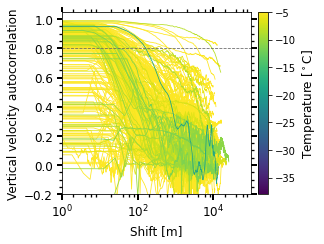

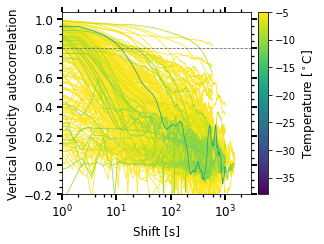

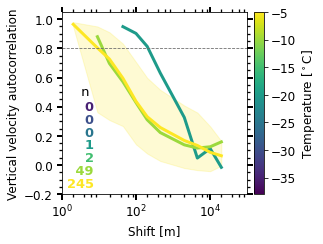

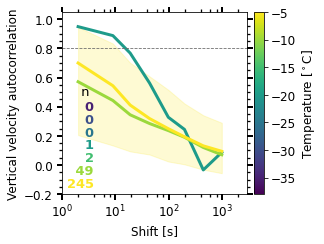

In [133]:

def plot_autocorr(clouds, hvel_corr=None):
    fig, ax = plt.subplots(figsize=[4.6,3.5])

    cmap = matplotlib.cm.get_cmap('viridis')
    norm = matplotlib.colors.Normalize(vmin=-38.0, vmax=-5.0)
    
#     clouds = [c for c in clouds if -37 < float(c['CTT'])-273.15 < -32]

    print('identifier ctt hvel | cth_std thick_med thick_std ct_ac | indx vel_autocorr, total ', len(clouds))
    for cloud in clouds:

        ctt = float(cloud['CTT'])-273.15
        if hvel_corr:
            vel = max(float(cloud['VEL']),0.1)
        else:
            vel = 1
        
        autocor_time = toarray(cloud['v_dl_autocor_time'])
        autocor_coeff = toarray(cloud['v_dl_autocor_coeff'])
        
        autocorr_lt_thres = np.where(autocor_coeff > 0.8)[0]
        i_above_thres = autocorr_lt_thres[-1] if len(autocorr_lt_thres) > 0 else 0
        autocorr_at_thres = autocor_time[i_above_thres]*vel if len(autocor_time) > 0 else 0
        
        cth_std = float(cloud['CTH_STD'])
        thick_med = float(cloud['Cloud_Thickness_MED'])
        thick_std = float(cloud['Cloud_Thickness_STD'])
        ct_ac = float(cloud['CTH_autocorr_08_time'])

#         print(f"{cloud['A_Unique_Identifier']:>18} {ctt:6.2f} {vel:6.2f} |\
# {cth_std:6.1f} {thick_med:6.1f} {thick_std:6.1f} {ct_ac:6.1f} |\
# {i_above_thres:3} {autocorr_at_thres:7.2f}")
        ax.plot(autocor_time*vel, autocor_coeff, 
                linewidth=0.8,
                color=cmap(norm(ctt)))

    ax.axhline(0.8, linewidth=0.8, color='dimgrey', linestyle='--')
    ax.set_xscale('log')
    

    if hvel_corr:
        ax.set_xlim([1e0, 1e5])
        ax.set_xlabel('Shift [m]', fontsize=12)
    else:
        ax.set_xlim([1e0, 3e3])
        ax.set_xlabel('Shift [s]', fontsize=12)
    ax.set_ylabel('Vertical velocity autocorrelation', fontsize=12)
    ax.set_ylim([-0.2, 1.05])

    #ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.tick_params(axis='both', which='major', top=True, right=True,
                   width=1.5, length=4, labelsize=11)
    ax.tick_params(axis='both', which='minor', top=True, right=True,
                   width=1.5, length=2.5)
    #ax.legend(fontsize=12)
    ax.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12))
    ax.tick_params(axis='both', which='both', right=True, top=True)
    ax.tick_params(axis='both', which='major', labelsize=12,
                   width=2, length=5.5)
    ax.tick_params(axis='both', which='minor', width=1.3, length=3)

    from mpl_toolkits.axes_grid1 import make_axes_locatable

    divider = make_axes_locatable(plt.gca())
    ax_cb = divider.new_horizontal(size="5%", pad=0.1)    
    cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')
    plt.gcf().add_axes(ax_cb)
    cb1.set_label('Temperature [$^\circ$C]', fontsize=12)
    
    return fig, ax


def plot_autocorr_grouped(clouds, hvel_corr=None):
    fig, ax = plt.subplots(figsize=[4.6,3.5])

    cmap = matplotlib.cm.get_cmap('viridis')
    norm = matplotlib.colors.Normalize(vmin=-38.0, vmax=-5.0)

    print('identifier ctt hvel | cth_std thick_med thick_std ct_ac | indx vel_autocorr, total ', len(clouds))
    
    
#     for cloud in clouds:

#         ctt = float(cloud['CTT'])-273.15
#         if hvel_corr:
#             vel = max(float(cloud['VEL']),0.1)
#         else:
#             vel = 1
        
#         autocor_time = toarray(cloud['v_dl_autocor_time'])
#         autocor_coeff = toarray(cloud['v_dl_autocor_coeff'])
        
#         cth_std = float(cloud['CTH_STD'])
#         thick_med = float(cloud['Cloud_Thickness_MED'])
#         thick_std = float(cloud['Cloud_Thickness_STD'])
#         ct_ac = float(cloud['CTH_autocorr_08_time'])

# #         print(f"{cloud['A_Unique_Identifier']:>18} {ctt:6.2f} {vel:6.2f} |\
# # {cth_std:6.1f} {thick_med:6.1f} {thick_std:6.1f} {ct_ac:6.1f} |\
# # {i_above_thres:3} {autocorr_at_thres:7.2f}")
#         ax.plot(autocor_time*vel, autocor_coeff, 
#                 linewidth=0.8,
#                 color=cmap(norm(ctt)))
    
    
    temp_bin_edges = np.arange(-37.5,1,5)
    
    for j,(l,r) in enumerate(zip(temp_bin_edges[:-1], temp_bin_edges[1:])):        
        c_filt = [c for c in clouds if l < float(c['CTT'])-273.15 < r]
        print(l,r, 'no clouds', len(c_filt))
        
        ax.text(0.17, 0.46-(0.07*j), f'{len(c_filt):>5}',
                fontsize=13, fontweight='semibold',
                color=cmap(norm(np.mean([l,r]))),
                horizontalalignment='right',
                transform=ax.transAxes)
        if len(c_filt) == 0:
            continue

        autocor_time = np.zeros((len(c_filt), 500))
        autocor_coeff = np.zeros((len(c_filt), 500))
        for i, c in enumerate(c_filt):
        
            if hvel_corr:
                vel = max(float(c['VEL']),0.1)
            else:
                vel = 1
                
            coeffs = toarray(c['v_dl_autocor_coeff'])
            autocor_time[i,:len(coeffs)] = toarray(c['v_dl_autocor_time'])*vel
            autocor_coeff[i,:len(coeffs)] = coeffs

            # plain averaging is not sufficient, as the time/hor shift axis
            # is not uniform
            
        coeffs[coeffs < -0.2] = np.nan
        if hvel_corr:
            xbins = np.array([1e0,3e0,1e1,2e1,4.5e1,1e2,2e2,4.5e2,1e3,2e3,4.5e3,1e4,2e4])
            xbins = np.array([1e0,3e0,1e1,2e1,4.5e1,1e2,2e2,4.5e2,2e3,4.5e3,1e4,2e4])
        else:
            xbins = np.array([1e0,3e0,1e1,2e1,4.5e1,1e2,2e2,4.5e2,1e3])
        
        mask = np.logical_or(~np.isfinite(autocor_time), ~np.isfinite(autocor_coeff))
        mean, bin_edges, no = stats.binned_statistic(
            autocor_time[~mask].ravel(), autocor_coeff[~mask].ravel(),
            statistic='mean', bins=xbins
        )
        perc10, _, _ = stats.binned_statistic(
            autocor_time[~mask].ravel(), autocor_coeff[~mask].ravel(),
            statistic=lambda y: np.percentile(y, 10), bins=xbins
        )
        perc90, _, _ = stats.binned_statistic(
            autocor_time[~mask].ravel(), autocor_coeff[~mask].ravel(),
            statistic=lambda y: np.percentile(y, 90), bins=xbins
        )
        counts, _, _ = stats.binned_statistic(
            autocor_time[~mask].ravel(), autocor_coeff[~mask].ravel(),
            statistic='std', bins=xbins
        )
        
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2
        
        print(bin_centers)
        print('mean', mean)
        print('std', counts)
        ax.plot(bin_centers, mean, 
            linewidth=3,
            color=cmap(norm(np.mean([l,r]))))
#         ax.plot(bin_centers, perc10, 
#             linewidth=1,
#             color=cmap(norm(np.mean([l,r]))))
#         ax.plot(bin_centers, perc90, 
#             linewidth=1,
#             color=cmap(norm(np.mean([l,r]))))

        if j == 1 or j==len(temp_bin_edges)-2:
            print(j, l, r)
            ax.fill_between(bin_centers, perc10, perc90, color=cmap(norm(np.mean([l,r]))), alpha=0.2)
        

    
    ax.text(0.17, 0.545, '  n ',
            fontsize=13,
            horizontalalignment='right',
            transform=ax.transAxes)

    ax.axhline(0.8, linewidth=0.8, color='dimgrey', linestyle='--')
    ax.set_xscale('log')
    

    if hvel_corr:
        ax.set_xlim([1e0, 1e5])
        ax.set_xlabel('Shift [m]', fontsize=12)
    else:
        ax.set_xlim([1e0, 3e3])
        ax.set_xlabel('Shift [s]', fontsize=12)
    ax.set_ylabel('Vertical velocity autocorrelation', fontsize=12)
    ax.set_ylim([-0.2, 1.05])

    #ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.tick_params(axis='both', which='major', top=True, right=True,
                   width=1.5, length=4, labelsize=11)
    ax.tick_params(axis='both', which='minor', top=True, right=True,
                   width=1.5, length=2.5)
    #ax.legend(fontsize=12)
    ax.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12))
    ax.tick_params(axis='both', which='both', right=True, top=True)
    ax.tick_params(axis='both', which='major', labelsize=12,
                   width=2, length=5.5)
    ax.tick_params(axis='both', which='minor', width=1.3, length=3)

    from mpl_toolkits.axes_grid1 import make_axes_locatable

    divider = make_axes_locatable(plt.gca())
    ax_cb = divider.new_horizontal(size="5%", pad=0.1)    
    cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')

    plt.gcf().add_axes(ax_cb)
    cb1.set_label('Temperature [$^\circ$C]', fontsize=12)
    cb1.ax.tick_params(labelsize=12) 
    
    return fig, ax


fig, ax = plot_autocorr(clouds_standard['liquid_only'], hvel_corr=True)
fig.tight_layout()
fname = f'../plots/v_timeseries/{larda_name}_dl_vel_autocorrelation.png'
fig.savefig(fname, dpi=250)

print('================================')
fig, ax = plot_autocorr(clouds_standard['liquid_only'], hvel_corr=False)
fig.tight_layout()
fname = f'../plots/v_timeseries/{larda_name}_dl_vel_autocorrelation_s.png'
fig.savefig(fname, dpi=250)

fig, ax = plot_autocorr_grouped(clouds_standard['liquid_only'], hvel_corr=True)
fig.tight_layout()
fname = f'../plots/v_timeseries/{larda_name}_dl_vel_autocorrelation_grouped.png'
fig.savefig(fname, dpi=250)

fig, ax = plot_autocorr_grouped(clouds_standard['liquid_only'], hvel_corr=False)
fig.tight_layout()
fname = f'../plots/v_timeseries/{larda_name}_dl_vel_autocorrelation_s_grouped.png'
fig.savefig(fname, dpi=250)


-37.5 -32.5 no clouds 0
-32.5 -27.5 no clouds 0
-27.5 -22.5 no clouds 0
-22.5 -17.5 no clouds 1
[2.0000e-05 9.0000e-05 1.9000e-04 4.4000e-04 9.9000e-04 1.9900e-03
 4.4900e-03 9.9900e-03 1.9990e-02 4.4990e-02 9.9990e-02 1.9999e-01]
[       nan        nan 3.83149004 1.81818902 0.12256441 0.05644305
 0.01889946 0.01047749 0.00460654        nan        nan        nan]
-17.5 -12.5 no clouds 2
[2.0000e-05 9.0000e-05 1.9000e-04 4.4000e-04 9.9000e-04 1.9900e-03
 4.4900e-03 9.9900e-03 1.9990e-02 4.4990e-02 9.9990e-02 1.9999e-01]
[nan nan nan nan nan nan nan nan nan nan nan nan]
-12.5 -7.5 no clouds 49
[2.0000e-05 9.0000e-05 1.9000e-04 4.4000e-04 9.9000e-04 1.9900e-03
 4.4900e-03 9.9900e-03 1.9990e-02 4.4990e-02 9.9990e-02 1.9999e-01]
[       nan 4.01964331 2.11914921 1.42026937 1.86946392 0.91791797
 0.48830289 0.19938903 0.05986446 0.02941224 0.0120193  0.01423067]
-7.5 -2.5 no clouds 245
[2.0000e-05 9.0000e-05 1.9000e-04 4.4000e-04 9.9000e-04 1.9900e-03
 4.4900e-03 9.9900e-03 1.9990e-02 4.4990

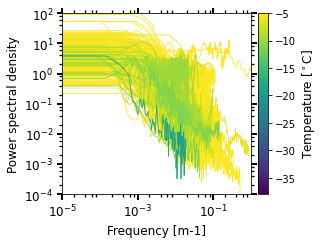

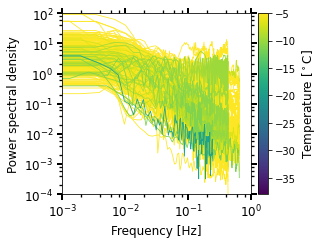

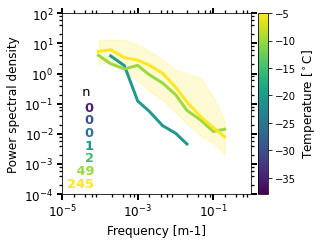

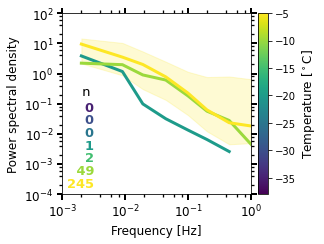

In [134]:

def plot_periodogram(clouds, hvel_corr=None):
    fig, ax = plt.subplots(figsize=[4.6,3.5])

    cmap = matplotlib.cm.get_cmap('viridis')
    norm = matplotlib.colors.Normalize(vmin=-38.0, vmax=-5.0)
    
    

    for cloud in clouds[:]:

        ctt = float(cloud['CTT'])-273.15
        if hvel_corr:
            vel = max(float(cloud['VEL']),0.1)
        else:
            vel = 1
        #print(cloud['A_Unique_Identifier'], ctt, vel)
        period_f = toarray(cloud['v_dl_period_f'])
        period_Pxx = toarray(cloud['v_dl_period_Pxx'])
        ax.plot(period_f/vel, np.abs(period_Pxx), 
                linewidth=0.8,
                color=cmap(norm(ctt)))

    ax.set_yscale('log')
    ax.set_xscale('log')

    if hvel_corr:
        ax.set_xlim([1e-5, 1e0])
        ax.set_xlabel('Frequency [m-1]', fontsize=12)
    else:
        ax.set_xlim([1e-3, 1e0])
        ax.set_xlabel('Frequency [Hz]', fontsize=12)
    ax.set_ylabel('Power spectral density', fontsize=12)
    ax.set_ylim([1e-4, 1e2])

    ax.tick_params(axis='both', which='major', top=True, right=True,
                   width=1.5, length=4, labelsize=11)
    ax.tick_params(axis='both', which='minor', top=True, right=True,
                   width=1.5, length=2.5)
    #ax.legend(fontsize=12)
    ax.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12))
    ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12))
    ax.tick_params(axis='both', which='both', right=True, top=True)
    ax.tick_params(axis='both', which='major', labelsize=12,
                   width=2, length=5.5)
    ax.tick_params(axis='both', which='minor', width=1.3, length=3)

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    divider = make_axes_locatable(plt.gca())
    ax_cb = divider.new_horizontal(size="5%", pad=0.1)    
    cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')
    plt.gcf().add_axes(ax_cb)
    cb1.set_label('Temperature [$^\circ$C]', fontsize=12)
    
    return fig, ax


def plot_periodogram_grouped(clouds, hvel_corr=None):
    fig, ax = plt.subplots(figsize=[4.6,3.5])

    cmap = matplotlib.cm.get_cmap('viridis')
    norm = matplotlib.colors.Normalize(vmin=-38.0, vmax=-5.0)

#     for cloud in clouds[:]:

#         ctt = float(cloud['CTT'])-273.15
#         if hvel_corr:
#             vel = max(float(cloud['VEL']),0.1)
#         else:
#             vel = 1
#         #print(cloud['A_Unique_Identifier'], ctt, vel)
#         period_f = toarray(cloud['v_dl_period_f'])
#         period_Pxx = toarray(cloud['v_dl_period_Pxx'])
#         ax.plot(period_f/vel, np.abs(period_Pxx), 
#                 linewidth=0.8,
#                 color=cmap(norm(ctt)))
        
        
    temp_bin_edges = np.arange(-37.5,1,5)

    for j,(l,r) in enumerate(zip(temp_bin_edges[:-1], temp_bin_edges[1:])):        
        c_filt = [c for c in clouds if l < float(c['CTT'])-273.15 < r]
        print(l,r, 'no clouds', len(c_filt))
        
        ax.text(0.17, 0.46-(0.07*j), f'{len(c_filt):>5}',
            fontsize=13, fontweight='semibold',
            color=cmap(norm(np.mean([l,r]))),
            horizontalalignment='right',
            transform=ax.transAxes)
        if len(c_filt) == 0:
            continue

        period_f = np.zeros((len(c_filt), 500))
        period_Pxx = np.zeros((len(c_filt), 500))
        for i, c in enumerate(c_filt):
        
            if hvel_corr:
                vel = max(float(c['VEL']),0.1)
            else:
                vel = 1
                
            pxx = toarray(c['v_dl_period_Pxx'])
            period_f[i,:len(pxx)] = toarray(c['v_dl_period_f'])/vel
            period_Pxx[i,:len(pxx)] = pxx

            # plain averaging is not sufficient, as the time/hor shift axis
            # is not uniform
            
        if hvel_corr:
            #xbins = np.array([1e0,3e0,1e1,2e1,4.5e1,1e2,2e2,4.5e2,1e3,2e3,4.5e3,1e4,2e4])
            xbins = np.array([1e-5,3e-5,1e-4,2e-4,4.5e-4,1e-3,2e-3,4.5e-3,1e-2,2e-2,4.5e-2,1e-1,2e-1])
            #xbins = np.array([1e-6,3e-5,1e-4,2e-4,4.5e-4,1e-3,2e-3,4.5e-3,1e-2,2e-2,4.5e-2,1e-1,2e-1])
        else:
            #xbins = np.array([1e0,3e0,1e1,2e1,4.5e1,1e2,2e2,4.5e2,1e3])
            xbins = np.array([1e-3,3e-3,1e-2,2e-2,4.5e-2,1e-1,2e-1,4.5e-1,1e0])
            #xbins = np.array([1e-4,3e-3,1e-2,2e-2,4.5e-2,1e-1,2e-1,4.5e-1,1e0])
        
        mask = np.logical_or(~np.isfinite(period_f), ~np.isfinite(period_Pxx))
        mean, bin_edges, no = stats.binned_statistic(
            period_f[~mask].ravel(), period_Pxx[~mask].ravel(),
            statistic='median', bins=xbins
        )
        perc10, _, _ = stats.binned_statistic(
            period_f[~mask].ravel(), period_Pxx[~mask].ravel(),
            statistic=lambda y: np.percentile(y, 10), bins=xbins
        )
        perc90, _, _ = stats.binned_statistic(
            period_f[~mask].ravel(), period_Pxx[~mask].ravel(),
            statistic=lambda y: np.percentile(y, 90), bins=xbins
        )

        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2
        
        print(bin_centers)
        print(mean)
        ax.plot(bin_centers, mean, 
            linewidth=3,
            color=cmap(norm(np.mean([l,r]))))
#         ax.plot(bin_centers, perc10, 
#             linewidth=1,
#             color=cmap(norm(np.mean([l,r]))))
#         ax.plot(bin_centers, perc90, 
#             linewidth=1,
#             color=cmap(norm(np.mean([l,r]))))

        if j == 1 or j==len(temp_bin_edges)-2:
            print(j, l, r)

            ax.fill_between(bin_centers, perc10, perc90, color=cmap(norm(np.mean([l,r]))), alpha=0.2)
        

    
    ax.text(0.17, 0.545, '  n ',
            fontsize=13,
            horizontalalignment='right',
            transform=ax.transAxes)

    ax.set_yscale('log')
    ax.set_xscale('log')

    if hvel_corr:
        ax.set_xlim([1e-5, 1e0])
        ax.set_xlabel('Frequency [m-1]', fontsize=12)
    else:
        ax.set_xlim([1e-3, 1e0])
        ax.set_xlabel('Frequency [Hz]', fontsize=12)
    ax.set_ylabel('Power spectral density', fontsize=12)
    ax.set_ylim([1e-4, 1e2])

    ax.tick_params(axis='both', which='major', top=True, right=True,
                   width=1.5, length=4, labelsize=11)
    ax.tick_params(axis='both', which='minor', top=True, right=True,
                   width=1.5, length=2.5)
    #ax.legend(fontsize=12)
    ax.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12))
    ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12))
    ax.tick_params(axis='both', which='both', right=True, top=True)
    ax.tick_params(axis='both', which='major', labelsize=12,
                   width=2, length=5.5)
    ax.tick_params(axis='both', which='minor', width=1.3, length=3)

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    divider = make_axes_locatable(plt.gca())
    ax_cb = divider.new_horizontal(size="5%", pad=0.1)    
    cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')
    plt.gcf().add_axes(ax_cb)
    cb1.set_label('Temperature [$^\circ$C]', fontsize=12)
    
    return fig, ax



fig, ax = plot_periodogram(clouds_standard['liquid_only'], hvel_corr=True)
fig.tight_layout()
fname = f'../plots/v_timeseries/{larda_name}_dl_vel_periodogram.png'
fig.savefig(fname, dpi=250)

fig, ax = plot_periodogram(clouds_standard['liquid_only'], hvel_corr=False)
fig.tight_layout()
fname = f'../plots/v_timeseries/{larda_name}_dl_vel_periodogram_s.png'
fig.savefig(fname, dpi=250)

# fig.savefig('{}_dl_vel_spectrum.png'.format(time_interval[0].strftime("%Y%m%d_%H%M")), dpi=250)
# fname = '../plots/v_timeseries/dl_vel_autocorrelation.png'
# fig.savefig(fname, dpi=250)

fig, ax = plot_periodogram_grouped(clouds_standard['liquid_only'], hvel_corr=True)
fig.tight_layout()
fname = f'../plots/v_timeseries/{larda_name}_dl_vel_periodogram_grouped.png'
fig.savefig(fname, dpi=250)

fig, ax = plot_periodogram_grouped(clouds_standard['liquid_only'], hvel_corr=False)
fig.tight_layout()
fname = f'../plots/v_timeseries/{larda_name}_dl_vel_periodogram_s_grouped.png'
fig.savefig(fname, dpi=250)

identifier ctt hvel | cth_std thick_med thick_std ct_ac | indx vel_autocorr, total  501
identifier ctt hvel | cth_std thick_med thick_std ct_ac | indx vel_autocorr, total  501
identifier ctt hvel | cth_std thick_med thick_std ct_ac | indx vel_autocorr, total  501
-37.5 -32.5 no clouds 4
[2.0000e+00 9.0000e+00 1.9000e+01 4.4000e+01 9.9000e+01 1.9900e+02
 4.4900e+02 1.9990e+03 4.4990e+03 9.9990e+03 1.9999e+04]
mean [        nan         nan  0.43149331  0.6098588   0.33471132  0.20443125
  0.08763156  0.0717981   0.05381182  0.02944712 -0.00847791]
std [0.         0.         0.         0.18902268 0.10412756 0.06151055
 0.02997705 0.03618322 0.03016478 0.03804822 0.01892975]
-32.5 -27.5 no clouds 16
[2.0000e+00 9.0000e+00 1.9000e+01 4.4000e+01 9.9000e+01 1.9900e+02
 4.4900e+02 1.9990e+03 4.4990e+03 9.9990e+03 1.9999e+04]
mean [       nan        nan 0.77804426 0.51626445 0.46496285 0.28832545
 0.1728854  0.1223943  0.07615727 0.03532341 0.00467296]
std [0.         0.         0.09679789 0.36

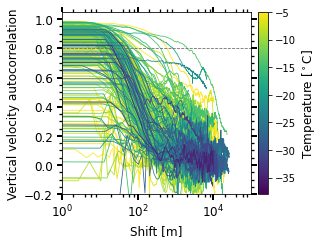

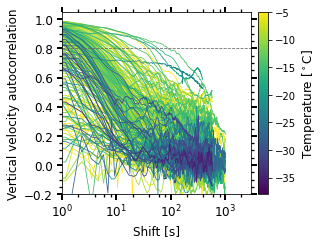

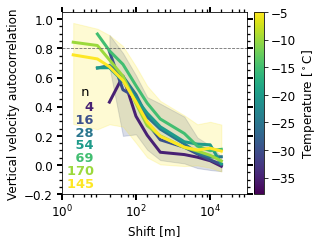

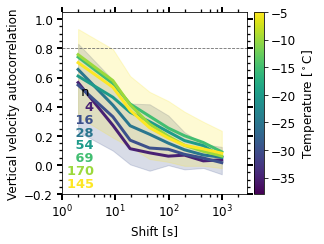

In [135]:
fig, ax = plot_autocorr(clouds_standard['ice_producing'], hvel_corr=True)
fig.tight_layout()
fname = f'../plots/v_timeseries/{larda_name}_dl_vel_autocorrelation_ice_prod.png'
fig.savefig(fname, dpi=250)

fig, ax = plot_autocorr(clouds_standard['ice_producing'], hvel_corr=False)
fig.tight_layout()
fname = f'../plots/v_timeseries/{larda_name}_dl_vel_autocorrelation_s_ice_prod.png'
fig.savefig(fname, dpi=250)

fig, ax = plot_autocorr_grouped(clouds_standard['ice_producing'], hvel_corr=True)
fig.tight_layout()
fname = f'../plots/v_timeseries/{larda_name}_dl_vel_autocorrelation_ice_prod_grouped.png'
fig.savefig(fname, dpi=250)

fig, ax = plot_autocorr_grouped(clouds_standard['ice_producing'], hvel_corr=False)
fig.tight_layout()
fname = f'../plots/v_timeseries/{larda_name}_dl_vel_autocorrelation_s_ice_prod_grouped.png'
fig.savefig(fname, dpi=250)


-37.5 -32.5 no clouds 4
[2.0000e-05 9.0000e-05 1.9000e-04 4.4000e-04 9.9000e-04 1.9900e-03
 4.4900e-03 9.9900e-03 1.9990e-02 4.4990e-02 9.9990e-02 1.9999e-01]
[       nan        nan 2.26770473 2.76430583 2.19469309 2.15334308
 0.70270836 0.21561989 0.04984635 0.03346427        nan        nan]
-32.5 -27.5 no clouds 16
[2.0000e-05 9.0000e-05 1.9000e-04 4.4000e-04 9.9000e-04 1.9900e-03
 4.4900e-03 9.9900e-03 1.9990e-02 4.4990e-02 9.9990e-02 1.9999e-01]
[       nan 1.93497396 2.79451591 2.57153726 1.96029246 1.27739465
 0.45329526 0.13133931 0.04978749 0.02522488        nan        nan]
1 -32.5 -27.5
-27.5 -22.5 no clouds 28
[2.0000e-05 9.0000e-05 1.9000e-04 4.4000e-04 9.9000e-04 1.9900e-03
 4.4900e-03 9.9900e-03 1.9990e-02 4.4990e-02 9.9990e-02 1.9999e-01]
[       nan 5.07482672 5.28920758 3.13415658 2.71851563 1.85004056
 0.75829744 0.21974897 0.08923876 0.03923872 0.02041033 0.00774339]
-22.5 -17.5 no clouds 54
[2.0000e-05 9.0000e-05 1.9000e-04 4.4000e-04 9.9000e-04 1.9900e-03
 4.4900e-0

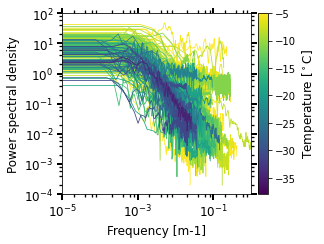

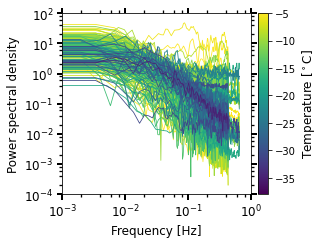

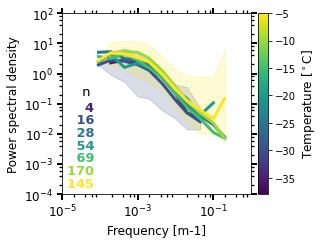

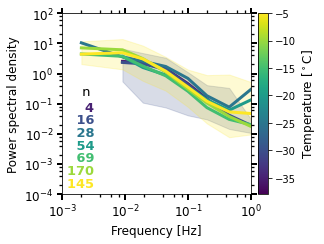

In [136]:
fig, ax = plot_periodogram(clouds_standard['ice_producing'], hvel_corr=True)
fig.tight_layout()
fname = f'../plots/v_timeseries/{larda_name}_dl_vel_periodogram_ice_prod.png'
fig.savefig(fname, dpi=250)


fig, ax = plot_periodogram(clouds_standard['ice_producing'], hvel_corr=False)
fig.tight_layout()
fname = f'../plots/v_timeseries/{larda_name}_dl_vel_periodogram_s_ice_prod.png'
fig.savefig(fname, dpi=250)


fig, ax = plot_periodogram_grouped(clouds_standard['ice_producing'], hvel_corr=True)
fig.tight_layout()
fname = f'../plots/v_timeseries/{larda_name}_dl_vel_periodogram_ice_prod_grouped.png'
fig.savefig(fname, dpi=250)

fig, ax = plot_periodogram_grouped(clouds_standard['ice_producing'], hvel_corr=False)
fig.tight_layout()
fname = f'../plots/v_timeseries/{larda_name}_dl_vel_periodogram_s_ice_prod_grouped.png'
fig.savefig(fname, dpi=250)

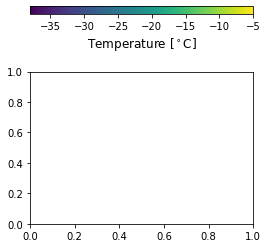

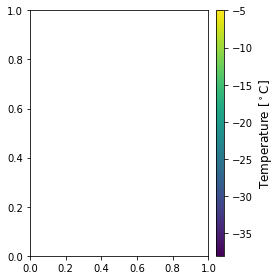

In [137]:

    
fig, axes = plt.subplots(figsize=[4,4])

cmap = matplotlib.cm.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin=-38.0, vmax=-5.0)

from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_vertical(size="5%", pad=0.8)    

cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')

plt.gcf().add_axes(ax_cb)

cb1.set_label('Temperature [$^\circ$C]', fontsize=12)

fname = f'../plots/v_timeseries/colorbar_hor_single.png'
fig.savefig(fname, dpi=250)


fig, axes = plt.subplots(figsize=[4,4])

cmap = matplotlib.cm.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin=-38.0, vmax=-5.0)

from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.1)    


cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                norm=norm,
                                orientation='vertical')

plt.gcf().add_axes(ax_cb)

cb1.set_label('Temperature [$^\circ$C]', fontsize=12)
fig.tight_layout()
fname = f'../plots/v_timeseries/colorbar_ver_single.png'
fig.savefig(fname, dpi=250)

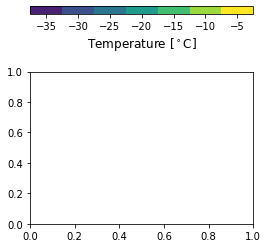

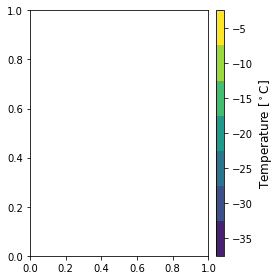

In [138]:
fig, axes = plt.subplots(figsize=[4,4])

cmap = matplotlib.cm.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin=-38.0, vmax=-5.0)

temp_bin_edges = np.arange(-37.5,1,5)
temp_bin_mids = temp_bin_edges[:-1] + 0.5*(temp_bin_edges[1:] - temp_bin_edges[:-1])

discr_colors = matplotlib.colors.ListedColormap([cmap(norm(np.mean(t))) for t in temp_bin_mids])

norm = matplotlib.colors.Normalize(vmin=temp_bin_edges[0], vmax=temp_bin_edges[-1])

from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_vertical(size="5%", pad=0.8)    

cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=discr_colors,
                                norm=norm,
                                orientation='horizontal')

plt.gcf().add_axes(ax_cb)

cb1.set_label('Temperature [$^\circ$C]', fontsize=12)

fname = f'../plots/v_timeseries/colorbar_hor_single_discrete.png'
fig.savefig(fname, dpi=250)


fig, axes = plt.subplots(figsize=[4,4])


from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.1)    


cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=discr_colors,
                                norm=norm,
                                orientation='vertical')

plt.gcf().add_axes(ax_cb)

cb1.set_label('Temperature [$^\circ$C]', fontsize=12)
fig.tight_layout()
fname = f'../plots/v_timeseries/colorbar_ver_single_discrete.png'
fig.savefig(fname, dpi=250)